In [1]:
import time
from flash_attn.flash_attn_interface import (
    flash_attn_func, 
    flash_attn_varlen_func,
)

import torch
import attn_additive as attn
from attn_additive import (
    get_qkv,
)

In [2]:
llama8b_config = dict(
    head_dim=128,
    n_qo_head=32,
    n_kv_head=8,
)


In [3]:
def hread(x):
    if x < 1024:
        return f"{x}"
    if x < 1024**2:
        return f"{x/1024:.1f}K"
    if x < 1024**3:
        return f"{x/1024**2:.1f}M"
    if x < 1024**4:
        return f"{x/1024**3:.1f}G"
    if x < 1024**5:
        return f"{x/1024**4:.1f}T"
def hlist(x):
    return [hread(i) for i in x]

In [ ]:
import multiprocessing as mp

In [4]:
for sf in range(0, 8): # 1k -> 128k
    for bs in [1,2,3,4] + [8, 16, 32, 64]:
        seq_len = 1024 * (2 ** sf)
        batch = [seq_len] * bs
        mem_requirement = attn.calculate_memory_requirement(
            batch, llama8b_config['head_dim'], llama8b_config['n_qo_head'], llama8b_config['n_kv_head'],
            dtype=torch.float16,
        )
        print(f"{bs=},{sf=},mem: {hread(mem_requirement)}")
        if mem_requirement > 60 * 1024**3:
            print(f"skipping {bs=},{sf=},mem: {hread(mem_requirement)}")
            continue
        
        duration = attn.measure_flash_attn_duration_single_batch(llama8b_config, batch, 10, 30)
        print(f"Duration for {bs=}, {sf=}: {duration:.2f} ms")
    pass

bs=1,sf=0,mem: 12.0M
Duration for bs=1, sf=0: 0.16 ms
bs=2,sf=0,mem: 24.0M
Duration for bs=2, sf=0: 0.22 ms
bs=3,sf=0,mem: 36.0M
Duration for bs=3, sf=0: 0.27 ms
bs=4,sf=0,mem: 48.0M
Duration for bs=4, sf=0: 0.32 ms
bs=8,sf=0,mem: 96.0M
Duration for bs=8, sf=0: 0.54 ms
bs=16,sf=0,mem: 192.0M
Duration for bs=16, sf=0: 0.98 ms
bs=32,sf=0,mem: 384.0M
Duration for bs=32, sf=0: 1.85 ms
bs=64,sf=0,mem: 768.0M
Duration for bs=64, sf=0: 3.33 ms
bs=1,sf=1,mem: 24.0M
Duration for bs=1, sf=1: 0.31 ms
bs=2,sf=1,mem: 48.0M
Duration for bs=2, sf=1: 0.47 ms
bs=3,sf=1,mem: 72.0M
Duration for bs=3, sf=1: 0.64 ms
bs=4,sf=1,mem: 96.0M
Duration for bs=4, sf=1: 0.82 ms
bs=8,sf=1,mem: 192.0M
Duration for bs=8, sf=1: 1.49 ms
bs=16,sf=1,mem: 384.0M
Duration for bs=16, sf=1: 2.87 ms
bs=32,sf=1,mem: 768.0M
Duration for bs=32, sf=1: 5.67 ms
bs=64,sf=1,mem: 1.5G
Duration for bs=64, sf=1: 11.31 ms
bs=1,sf=2,mem: 48.0M
Duration for bs=1, sf=2: 0.82 ms
bs=2,sf=2,mem: 96.0M
Duration for bs=2, sf=2: 1.44 ms
bs=3,sf=2,

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 GiB. GPU 0 has a total capacity of 79.14 GiB of which 30.72 GiB is free. Including non-PyTorch memory, this process has 48.41 GiB memory in use. Of the allocated memory 48.00 GiB is allocated by PyTorch, and 2.00 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
data = """bs,sf,time
1,0,0.16
2,0,0.22
3,0,0.27
4,0,0.32
8,0,0.54
16,0,0.98
32,0,1.85
64,0,3.33
1,1,0.31
2,1,0.47
3,1,0.64
4,1,0.82
8,1,1.49
16,1,2.87
32,1,5.67
64,1,11.31
1,2,0.82
2,2,1.44
3,2,2.05
4,2,2.66
8,2,5.21
16,2,10.35
32,2,20.59
64,2,41.13
1,3,2.69
2,3,5.08
3,3,7.46
4,3,9.93
8,3,19.69
16,3,39.24
32,3,78.49
64,3,156.87
1,4,9.94
2,4,19.40
3,4,29.07
4,4,38.64
8,4,76.90
16,4,153.37
32,4,306.49
64,4,612.98
1,5,38.48
2,5,76.84
3,5,114.96
4,5,153.01
8,5,305.10
16,5,609.11
32,5,1218.03
64,5,2437.02
1,6,153.44
2,6,309.12
3,6,462.93
4,6,617.01
8,6,1232.75
16,6,2466.21
32,6,4932.65
"""

In [7]:
import pandas as pd
from io import StringIO

In [10]:
df = pd.read_csv(StringIO(data))

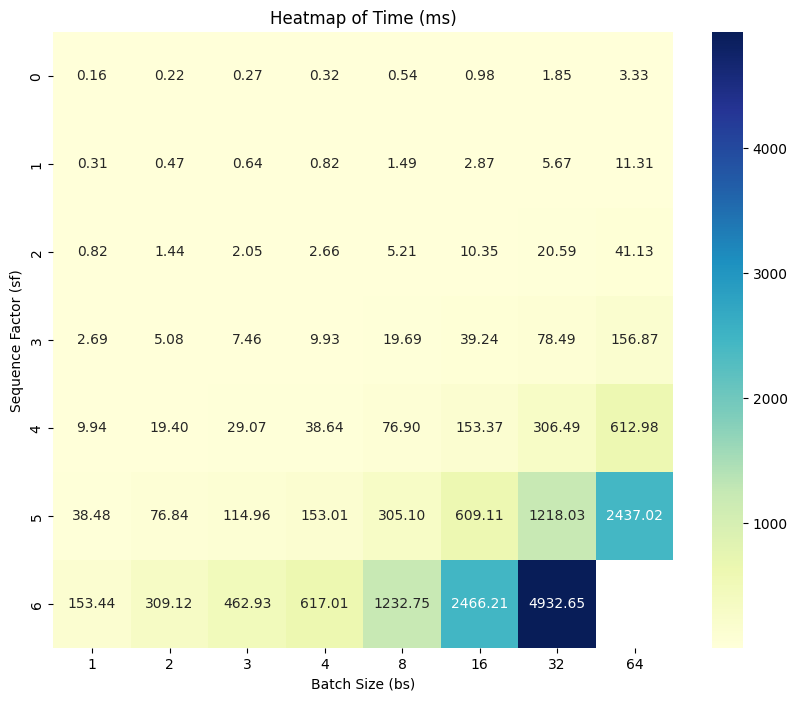

In [13]:
import seaborn as sns

import matplotlib.pyplot as plt

# Pivot the dataframe to create a matrix for the heatmap
heatmap_data = df.pivot(index="sf", columns="bs", values="time")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap of Time (ms)")
plt.xlabel("Batch Size (bs)")
plt.ylabel("Sequence Factor (sf)")
plt.show()